In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# --- Parameters ---
r = 0.05  # risk-free rate
T = 1     # time to expiry in years
today = pd.to_datetime("2024-06-06")  # valuation date
expiry = today + pd.Timedelta(days=365 * T)

# Load Spot Prices

In [ ]:
spot_df = pd.read_csv('data/AAPL.csv', parse_dates=['Date'])
spot_df['Close/Last'] = spot_df['Close/Last'].replace(r'[\$,]', '', regex=True).astype(float)
spot_df.set_index('Date', inplace=True)
spot_df = spot_df.sort_index()
spot = spot_df['Close/Last']
S0 = spot.iloc[-1]
print(f'Spot price (S0): {S0:.2f}')

Spot price (S0): 201.70


# Load Dividends (No forward-fill)

In [ ]:
divs = pd.read_csv('data/AAPL_dividends.csv', parse_dates=['Date'])
divs.set_index('Date', inplace=True)
divs = divs.sort_index()

# Compute PV of Future Dividends

In [ ]:
future_divs = divs.loc[(divs.index > today) & (divs.index <= expiry), 'Dividends']
pv_divs = (future_divs * np.exp(-r * ((future_divs.index - expiry).days / 365))).sum()
print(f'PV(future dividends): {pv_divs:.2f}')

PV(future dividends): 1.03


# Forward Prices

In [ ]:
q = divs['Dividends'].rolling(4).mean().iloc[-1] * 4 / S0  # estimate dividend yield from recent 4
F_cont = S0 * np.exp((r - q) * T)
F_disc = (S0 - pv_divs) * np.exp(r * T)
print(f'F_cont: {F_cont:.2f}, F_disc: {F_disc:.2f}')

F_cont: 210.98, F_disc: 210.96


# Scenario Payoff Table

In [ ]:
scenarios = {'Down 10%': 0.9 * S0, 'Base': S0, 'Up 10%': 1.1 * S0}
rows = []
for name, ST in scenarios.items():
    payoff = ST - F_cont
    pv_profit = np.exp(-r * T) * payoff
    rows.append({'Scenario': name, 'S_T': ST, 'Payoff': payoff, 'PV Profit': pv_profit})
payoff_df = pd.DataFrame(rows)
payoff_df.to_csv('forward_payoff_table.csv', index=False)
payoff_df.set_index('Scenario', inplace=True)

# Plotting the payoff scenarios

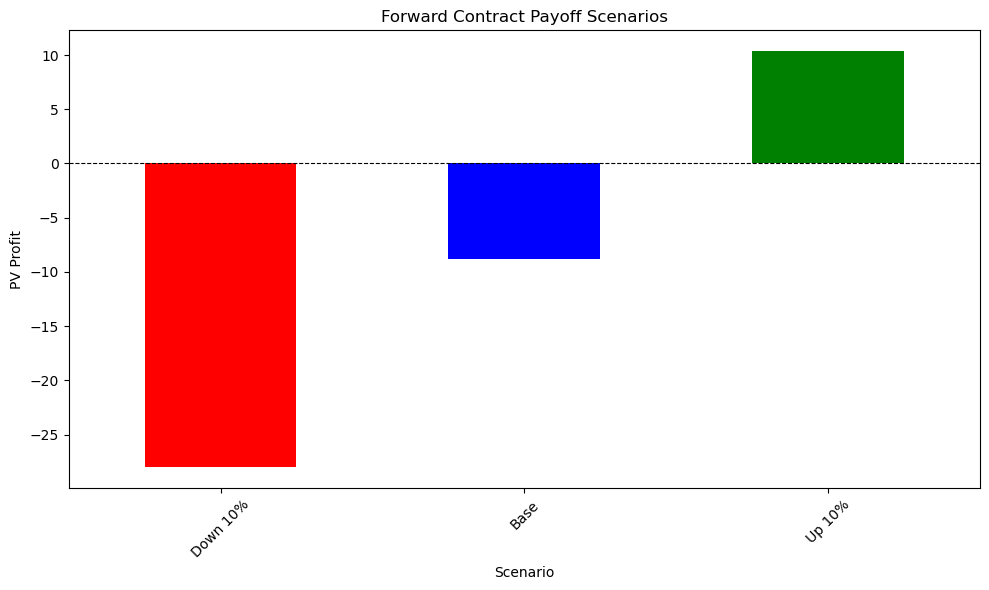

In [ ]:
plt.figure(figsize=(10, 6))
payoff_df['PV Profit'].plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Forward Contract Payoff Scenarios')
plt.xlabel('Scenario')
plt.ylabel('PV Profit')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('forward_payoff_scenarios.png')
plt.show()

# Display Payoff Table

In [ ]:
print("\nForward Contract Payoff Table:")
print(payoff_df)


Forward Contract Payoff Table:
             S_T    Payoff  PV Profit
Scenario                             
Down 10%  181.53 -29.45225 -28.015847
Base      201.70  -9.28225  -8.829550
Up 10%    221.87  10.88775  10.356748


# Display Forward Prices

In [ ]:
print(f"\nForward Price (Continuous Compounding): {F_cont:.2f}")
print(f"Forward Price (Discounted): {F_disc:.2f}")


Forward Price (Continuous Compounding): 210.98
Forward Price (Discounted): 210.96


# Arbitrage Strategy

In [ ]:
F_mkt = 155.00
strategy = (
    'Cash-and-carry: buy spot, finance, short forward'
    if F_mkt > F_cont
    else 'Reverse carry: short spot, invest proceeds, long forward'
)
print('Strategy:', strategy)

Strategy: Reverse carry: short spot, invest proceeds, long forward


# Payoff Plot

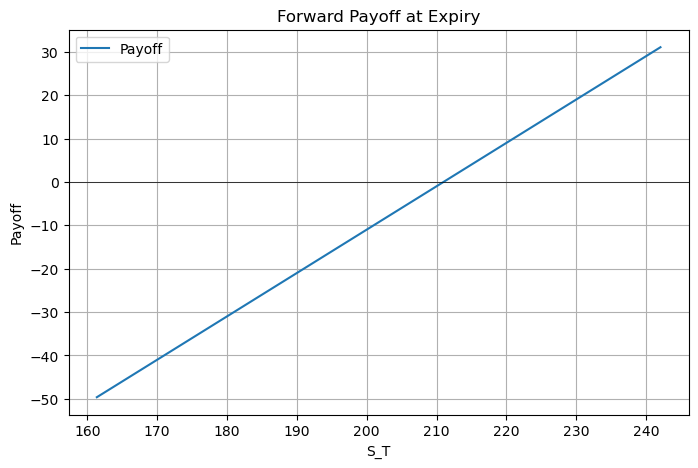

In [ ]:
ST_vals = np.linspace(0.8 * S0, 1.2 * S0, 100)
payoffs = ST_vals - F_cont
plt.figure(figsize=(8, 5))
plt.plot(ST_vals, payoffs, label='Payoff')
plt.axhline(0, color='black', lw=0.5)
plt.title('Forward Payoff at Expiry')
plt.xlabel('S_T')
plt.ylabel('Payoff')
plt.grid(True)
plt.legend()
plt.savefig('forward_payoff_plot.png')
plt.show()